In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sts

from sqlalchemy import create_engine

plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2.2
%matplotlib inline

In [2]:
# Set db variables
user = 'anthony'
pw = 'pw'
host = 'localhost:5432'
db_name = 'indicator_tests'

# Create engine for interacting with db
engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}/{db_name}')

### Get NASDAQ ETF list :


In [3]:
nas_etf = pd.read_csv('../data/NAS_ETF_List.csv')
nas_etf = nas_etf['Symbol'].to_list()

### SMA Entries

In [4]:
sma_nas = pd.read_sql_query(f'''SELECT ticker, sma_win
                                FROM sma_nasdaq
                                WHERE sma_buy = 1''',
                            con=engine)

In [5]:
sma_nas.dropna(inplace=True)

In [6]:
# Remove ETFs if exist
sma_nas = sma_nas[~sma_nas.ticker.isin(nas_etf)]

### Random Entries

In [7]:
rnd_nas = pd.read_sql_query(f'''SELECT ticker, rnd_win
                                FROM sma_nasdaq
                                WHERE rnd_buy = 1''',
                            con=engine)

In [8]:
# Remove ETFs if exist
rnd_nas = rnd_nas[~rnd_nas.ticker.isin(nas_etf)]

## T-test

In [9]:
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

t_stat, p_value = sts.ttest_ind(rnd_data, sma_data, equal_var=False)

print(f't_stat: {t_stat}\np_value: {p_value}')

t_stat: -0.543584428915917
p_value: 0.5867480026815965


## Begin plotting

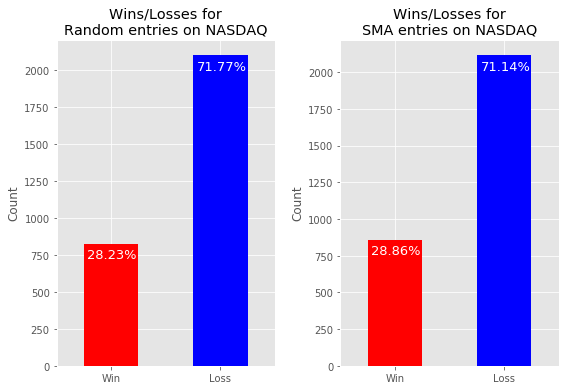

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,20))

axs[1] = sma_nas.sma_win.value_counts().plot(kind='bar',
                                         figsize=(9,6),
                                         title= 'Wins/Losses for\nSMA entries on NASDAQ',
                                         color=['blue', 'red'],
                                         ax=axs[1]
                                        )

axs[0] = rnd_nas.rnd_win.value_counts().plot(kind='bar',
                                         figsize=(9,6),
                                         title= 'Wins/Losses for\nRandom entries on NASDAQ',
                                         color=['blue', 'red'],
                                         ax=axs[0]
                                        )

for ax in axs: 
    ax.set_xticklabels(['Loss', 'Win'])
    ax.invert_xaxis()
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=0)
    
    totals = []
    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.468, i.get_height()-100, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=13,
                    color='white')

plt.subplots_adjust(wspace = 0.3)
plt.savefig('../images/winloss.png')        

In [17]:
# # This works for plotting, but not saving :(
# See cells below for further development

# def plot_power(H0, HA, alpha=.05, one_tailed=True, figsize=(20,20),
#                force_n=None):
#     """Plot a graphic showing the power of a hypothesis test.
    
#     Useful to explore how power relates to sample size, effect size,
#     significance, and standard deviation.
#     H0, Ha: ndarray or pd.Series
#     """
#     fig, ax = plt.subplots(1,1, figsize=figsize)
    
#     df = len(H0)-1
#     crit_val = sts.t.ppf(1-alpha, df) if one_tailed==True else sts.t.ppf(1-alpha/2, df)
    
#     if force_n:
#         n0 = force_n
#         nA = force_n
#     else:
#         n0 = len(H0)
#         nA = len(HA)
        
    
#     # Curve 1
#     mu0 = H0.mean()
#     std0 = H0.std()
#     sigma0 = std0/np.sqrt(n0)
#     x = np.linspace(mu0 - 5 * sigma0, mu0 + 5 * sigma0, 100)
#     ax.plot(x, sts.norm.pdf(x, mu0, sigma0), label =f"$H_0$\n$mu$={mu0:.3f}")

#     # Curve 2
#     muA = HA.mean()
#     stdA = HA.std()
#     sigmaA = stdA/np.sqrt(nA)
#     x = np.linspace(muA - 5 * sigmaA, muA + 5 * sigmaA, 100)
#     ax.plot(x, sts.norm.pdf(x, muA, sigmaA), color="black", label=f"$H_a$\n$mu$={muA:.3f}")

#     # Critical line
#     crit_line = (mu0 + crit_val * sigma0)
#     ax.axvline(crit_line, color='yellow', label=f"Rej. Boundary\n{crit_line:.3f}")
    
#     # Power region
#     x3 = np.linspace(crit_line, muA + 5 * sigma0, 100)
#     power = 1 - sts.norm(muA, sigmaA).cdf(crit_line)
#     ax.fill_between(x3, sts.norm.pdf(x3, muA, sigmaA), color='black', label=f"Power Region\n{power:.4f}")
    
#     ax.set_title(f'Test Power with alpha: {alpha}')
#     ax.legend(loc='upper left')
    
#     print(f"Diff. in means: {abs(mu0 - muA):.3f}")
#     print(f"Sample sizes: \n\tH0 {n0}\n\tHA {nA}")
#     print(f"Standard Errors: \n\tH0 {sigma0:.5f}\n\tHA {sigmaA:.5f}")


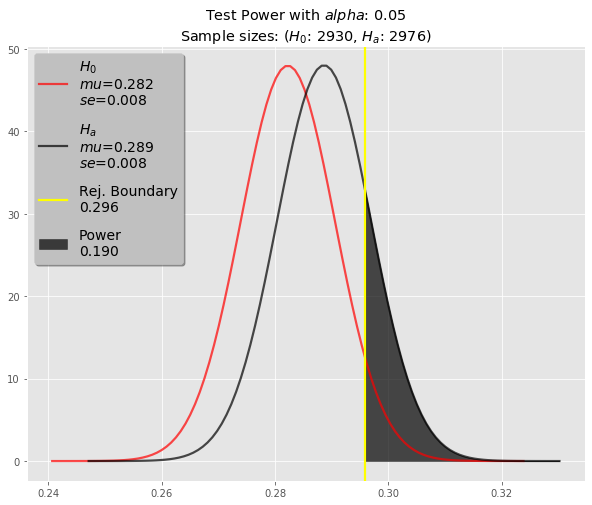

In [17]:
# Pull everything out of function so plt.savefig will work
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

H0 =rnd_data
HA =sma_data
alpha=.05
one_tailed=True
figsize=(10,8)
force_n=None

#####

fig, ax = plt.subplots(1,1, figsize=figsize)

df = len(H0)-1
crit_val = sts.t.ppf(1-alpha, df) if one_tailed==True else sts.t.ppf(1-alpha/2, df)

if force_n:
    n0 = force_n
    nA = force_n
else:
    n0 = len(H0)
    nA = len(HA)


# Curve 1
mu0 = H0.mean()
std0 = H0.std()
sigma0 = std0/np.sqrt(n0)
x = np.linspace(mu0 - 5 * sigma0, mu0 + 5 * sigma0, 100)
label1 = f"$H_0$\n$mu$={mu0:.3f}\n$se$={sigma0:.3f}"
ax.plot(x, sts.norm.pdf(x, mu0, sigma0), color="red", alpha=0.7, label=label1)

# Curve 2
muA = HA.mean()
stdA = HA.std()
sigmaA = stdA/np.sqrt(nA)
x = np.linspace(muA - 5 * sigmaA, muA + 5 * sigmaA, 100)
label2 = f"$H_a$\n$mu$={muA:.3f}\n$se$={sigmaA:.3f}"
ax.plot(x, sts.norm.pdf(x, muA, sigmaA), color="black", alpha=0.7, label=label2)


# Critical line
crit_line = (mu0 + crit_val * sigma0)
ax.axvline(crit_line, color='yellow', label=f"Rej. Boundary\n{crit_line:.3f}")

# Power region
x3 = np.linspace(crit_line, muA + 5 * sigmaA, 100)
power = 1 - sts.norm(muA, sigmaA).cdf(crit_line)
ax.fill_between(x3, sts.norm.pdf(x3, muA, sigmaA), color='black', alpha=0.7, label=f"Power\n{power:.3f}")

# T statistic
# t_line = (mu0 + t_stat * sigma0)
# ax.axvline(t_line, color='teal', linestyle=":", label=f"T-Stat\n{t_line:.3f}")

# x4 = np.linspace(t_line, mu0 + 5 * sigma0, 100)
# # t_area = 1 - sts.norm(mu0, sigma0).cdf(t_line)
# # ax.fill_between(x4, sts.norm.pdf(x4, mu0, sigma0), facecolor='none', edgecolor='teal', hatch='/')


ax.set_title(f'''Test Power with $alpha$: {alpha}
Sample sizes: ($H_0$: {n0}, $H_a$: {nA})''')

ax.legend(loc='upper left', fontsize=14, shadow=True, 
          facecolor='silver', labelspacing=1)


plt.savefig('../images/testpower.png')

In [22]:
1 - sts.norm(mu0, sigma0).cdf(t_line)


0.7066362613559466

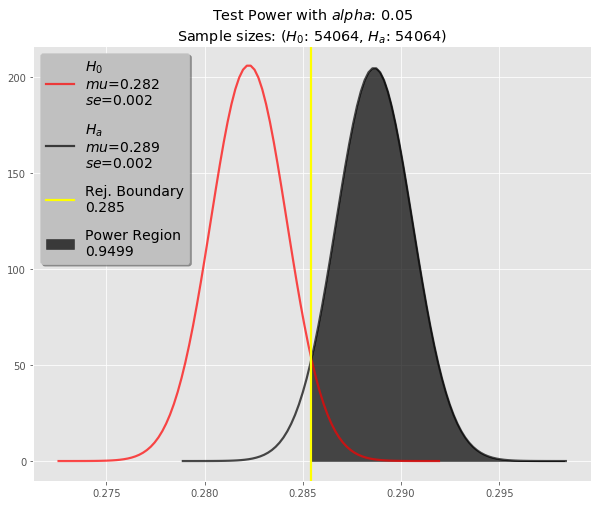

In [19]:
# Pull everything out of function so plt.savefig will work
# Forced large sample

rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

H0 =rnd_data
HA =sma_data
alpha=.05
one_tailed=True
figsize=(10,8)
force_n=54064

#####

fig, ax = plt.subplots(1,1, figsize=figsize)
c
df = len(H0)-1
crit_val = sts.t.ppf(1-alpha, df) if one_tailed==True else sts.t.ppf(1-alpha/2, df)

if force_n:
    n0 = force_n
    nA = force_n
else:
    n0 = len(H0)
    nA = len(HA)


# Curve 1
mu0 = H0.mean()
std0 = H0.std()
sigma0 = std0/np.sqrt(n0)
x = np.linspace(mu0 - 5 * sigma0, mu0 + 5 * sigma0, 100)
label1 = f"$H_0$\n$mu$={mu0:.3f}\n$se$={sigma0:.3f}"
ax.plot(x, sts.norm.pdf(x, mu0, sigma0), color='red', alpha=0.7, label=label1)

# Curve 2
muA = HA.mean()
stdA = HA.std()
sigmaA = stdA/np.sqrt(nA)
x = np.linspace(muA - 5 * sigmaA, muA + 5 * sigmaA, 100)
label2 = f"$H_a$\n$mu$={muA:.3f}\n$se$={sigmaA:.3f}"
ax.plot(x, sts.norm.pdf(x, muA, sigmaA), color="black", alpha=0.7, label=label2)

# Critical line
crit_line = (mu0 + crit_val * sigma0)
ax.axvline(crit_line, color='yellow', label=f"Rej. Boundary\n{crit_line:.3f}")

# Power region
x3 = np.linspace(crit_line, muA + 5 * sigma0, 100)
power = 1 - sts.norm(muA, sigmaA).cdf(crit_line)
ax.fill_between(x3, sts.norm.pdf(x3, muA, sigmaA), color='black', alpha=0.7, label=f"Power Region\n{power:.4f}")

ax.set_title(f'''Test Power with $alpha$: {alpha}
Sample sizes: ($H_0$: {n0}, $H_a$: {nA})''')

ax.legend(loc='upper left', fontsize=14, shadow=True, 
          facecolor='silver', labelspacing=1)

plt.savefig('../images/largenpower.png')

Get single stock for demo plot

In [10]:
query = '''
SELECT ticker, date, close, sma8, sma13, sma_buy 
FROM sma_nasdaq
WHERE ticker = 'MVIS'
'''

mvis = pd.read_sql_query(query, con=engine)
samp = mvis[100:200].copy()
samp.reset_index(inplace=True)

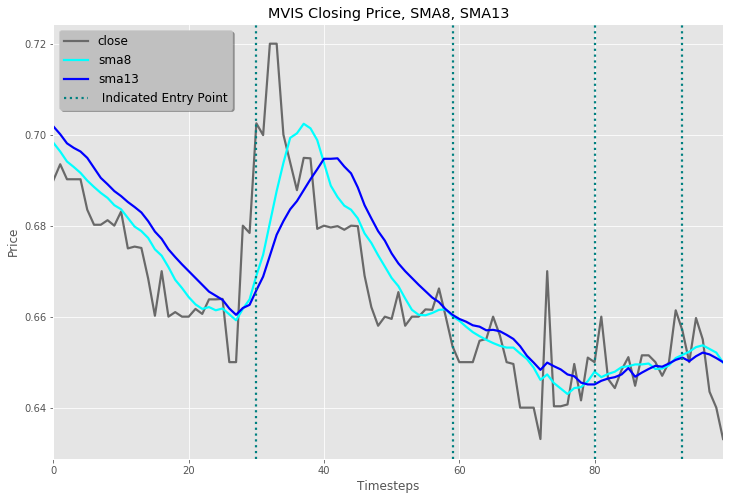

In [14]:
ax = samp.plot(x='date', y=['close','sma8','sma13'],
                        figsize=(12,8), use_index=False, 
                        title="MVIS Closing Price, SMA8, SMA13",
                        color=['dimgrey','cyan','blue']
                       )

ax.set_xlabel('Timesteps')
ax.set_ylabel('Price')

vertlines = samp.index[samp.sma_buy==1].tolist()
for line in vertlines:
    ax.axvline(line, color='teal', linestyle=':')

ax.axvline(101, color='teal', linestyle=':', label=' Indicated Entry Point')
ax.legend(loc='best', fontsize=12, shadow=True, 
          facecolor='silver')

plt.savefig('../images/pricechart.png')